python3 SpikeCounter/cluster/run_preprocess_stim_jobs2.py /n/holyscratch01/cohen_lab/bjia/20210921_25x_gcamp_focus/ None --remove_from_start 0 --remove_from_end 0 --n_pcs=40 --scale_factor=4 --skewness_threshold 0 --denoise 0 --pb_correct_method localmin --decorrelate 0 --start_from_downsampled 1 > jobs.txt

In [1]:
import sys
sys.path.append("../SpikeCounter")
import matplotlib as mpl
import numpy as np
import skimage.io as skio
import scipy.ndimage as ndi
import scipy.signal as signal
import scipy.stats as stats
import scipy.fft as fft
from skimage.measure import label
import matplotlib.pyplot as plt
from tifffile import imsave
import scipy.ndimage as ndimage
import matplotlib.colors as colors
import matplotlib.patches as patches
import colorcet as cc
from cycler import cycler
import os
from scipy import interpolate, optimize
from skimage import filters, transform, morphology, registration
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import mat73
import pandas as pd
import parse
import importlib
import pickle
import seaborn as sns

from spikecounter.analysis import traces, images
from spikecounter.ui import visualize, stackViewer
from spikecounter import utils

plt.style.use("../bio_pubs_presentation.mplstyle")
ss = StandardScaler()

In [2]:
def reload_libraries():
    importlib.reload(traces)
    importlib.reload(images)
    importlib.reload(visualize)
    importlib.reload(utils)

In [3]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20220203_gcamp_site_of_initiation/"
figdir = "/n/cohen_lab/Lab/Papers/First Heartbeat/Figures/v8"

In [4]:
subfolder = "corrected"
expt_info = utils.process_experiment_metadata(pd.read_csv(os.path.join(rootdir,"analysis", subfolder, "experiment_data.csv")),\
                                             regexp_dict={"embryo": r"(?<=E)\d+", 
                                                          "condition": r"[A-Z,a-z]+(?=_E\d)"})
expt_info = expt_info[expt_info["condition"].isnull()]
if "level_0" in expt_info:
    del(expt_info["level_0"])

In [5]:
um_per_px = 0.265*4

In [6]:
indices = np.arange(expt_info.shape[0])

In [ ]:
plt.close("all")
data = []
mint = []
maxdiv = []
erred_files = {}
smoothed_ts = {}
smoothed_ts_dv = {}
amplitudes = {}
divergences = {}
velocities = {}
for i in indices:
    filename = expt_info.iloc[i]["file_name"]
    snapt = "%s_snapt.npz" % filename
    if snapt in os.listdir(os.path.join(rootdir, "analysis", subfolder)) and "fast" in filename:
        matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
        ddict, t = utils.traces_to_dict(matdata)
        dt = np.mean(np.diff(t))
        
        beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]

        try:
            amplitude = (np.abs(beta[2] - 1)/beta[5])**2 #SNR
            db = 20*np.log10(amplitude)
            db[db < 0] = np.nan
            threshold = min(np.percentile(amplitude, 55), 1.01)
            q = images.analyze_wave_dynamics(beta, dt, um_per_px, deltax=13)
            if q is None:
                continue
            else:
                rd, Tsmoothed, Tsmoothed_dv, divergence, v = q
            rowdata = tuple(expt_info.iloc[i]) + rd
            data.append(rowdata)
            print(rowdata)
        except Exception as e:
            print(e)
            erred_files[filename] = e
            continue
        
        smoothed_ts[filename] = Tsmoothed_dv
        amplitudes[filename] = beta[2]
        divergences[filename] = divergence
        velocities[filename] = v
        visualize.plot_wave_analysis(db, Tsmoothed, Tsmoothed_dv,\
                           divergence, v, "%d, %s" % (i, expt_info.iloc[i]["file_name"]))
        plt.savefig(os.path.join(rootdir, "analysis", subfolder, filename, "waveplots.tif"))
        
data = pd.DataFrame(data, columns = expt_info.columns.tolist() + ['mean_speed', 'median_speed', 'loi_x',\
                                                                  'loi_y', 'loi_x_dv', 'loi_y_dv'])
#         break

In [ ]:
data.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"), index=False)

In [ ]:
with open(os.path.join(rootdir, "analysis", subfolder, "erred_files.pickle"), "wb") as f:
    pickle.dump(erred_files, f)

In [ ]:
wavemaps = {}
wavemaps["velocity"] = velocities
wavemaps["divergence"] = divergences
wavemaps["smoothed_ts"] = smoothed_ts
with open(os.path.join(rootdir, "analysis", subfolder, "wavemaps.pickle"), "wb") as f:
    pickle.dump(wavemaps, f)

Load processed data

In [6]:
import pickle
with open(os.path.join(rootdir, "analysis", subfolder, "wavemaps.pickle"), "rb") as f:
    wavemaps = pickle.load(f)
velocities = wavemaps["velocity"]
divergences = wavemaps["divergence"]
smoothed_ts = wavemaps["smoothed_ts"]


In [7]:
snap_info = utils.process_experiment_metadata(pd.read_csv(os.path.join(rootdir, "Snaps/analysis", "experiment_data.csv")),\
                                         regexp_dict={"embryo": r"(?<=E)\d+(?=_)", "nkx":r"nkx", "bf":r"bf", "fast":r"fast"})
snap_info = snap_info[snap_info["fast"]=="fast"]
snap_info_nkx = snap_info[[x is None for x in snap_info["bf"].tolist()]]
snap_info_bf = snap_info[snap_info["bf"]=="bf"]

In [8]:
data = pd.read_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"))
data["freq"] = np.nan
data["isi_mean"] = np.nan
data["isi_std"] = np.nan
data["n_pks"] = np.nan
for i in range(data.shape[0]):
    filename = data[["file_name"]].values.ravel()[i]
    with open(os.path.join(rootdir, "analysis", subfolder, filename, "temporal_statistics.pickle"), "rb") as f:
        temp_stats = pickle.load(f)
        for k, v in temp_stats.items():
            data.at[i, k] = v
data_nkx = utils.match_experiments_to_snaps(data, snap_info_nkx)
data_bf = utils.match_experiments_to_snaps(data, snap_info_bf)

Text(0, 0.5, 'Frequency (Hz)')

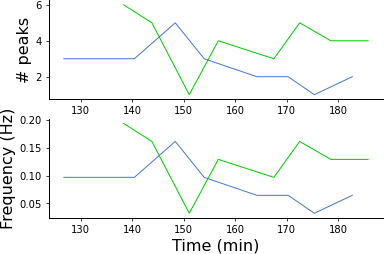

In [32]:
data_by_embryo = data.set_index("embryo")
p0=2
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    fig1, axes = plt.subplots(2,1, figsize=(6,4))
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[[embryo]]
        axes[0].plot(embryo_info["offset"]/60, embryo_info["n_pks"])    
        axes[1].plot(embryo_info["offset"]/60, embryo_info["freq"])
axes[1].set_xlabel("Time (min)")
axes[0].set_ylabel("# peaks")
axes[1].set_ylabel("Frequency (Hz)")

In [ ]:
data_by_embryo = data.set_index("embryo")
p0=2
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[[embryo]]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        axes = np.array([axes]).ravel()
        for i in range(embryo_info.shape[0]):
            filename = embryo_info[["file_name"]].values.ravel()[i]
            
            matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
            ddict, t = utils.traces_to_dict(matdata)
            dt = np.mean(np.diff(t))
            
            Tsmoothed_dv = smoothed_ts[filename]
            fv = Tsmoothed_dv[np.isfinite(Tsmoothed_dv)]
            Tsmoothed_apod = Tsmoothed_dv - np.percentile(fv, p0)
            axes[i].imshow(Tsmoothed_apod, vmin=0, vmax=450)
            axes[i].invert_yaxis()
            axes[i].set_axis_off()
            axes[i].set_title(embryo_info[["start_time"]].values.ravel()[i], fontsize=12)
        fig1.text(0.2, 0.1, "E%s" % str(embryo))
        plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_wavemap_montage.tif" % str(embryo)))

In [ ]:
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[[embryo]]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        axes = np.array([axes]).ravel()
        fig2, axes2 = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        axes2 = np.array([axes2]).ravel()
        corrected_images = []
        embryo_shifts = [[0,0]]
        
        for i in range(embryo_info.shape[0]):
            filename = embryo_info[["file_name"]].values.ravel()[i]
            img, _ = images.load_image(rootdir, filename, subfolder="downsampled")
            mean_img = np.mean(img, axis=0)
            skio.imsave(os.path.join(rootdir, "analysis", subfolder, filename, "mean_img.tif"), mean_img)
#             mean_img = skio.imread(os.path.join(rootdir, "analysis", subfolder, filename, "mean_img.tif"))
            axes[i].imshow(mean_img)
            axes[i].invert_yaxis()
            axes[i].set_axis_off()
            axes[i].set_title(embryo_info[["start_time"]].values.ravel()[i], fontsize=12)
            if i > 0:
                shift, _, _ = registration.phase_cross_correlation(corrected_images[-1], mean_img)
#                 print(shift)
                v, u = shift
                embryo_shifts.append(shift)
                nr, nc = mean_img.shape
                row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
                corrected_img = transform.warp(mean_img, np.array([row_coords-v, col_coords-u]), mode="edge")
#                 shift2 = registration.phase_cross_correlation(corrected_images[-1], corrected_img)
#                 v, u = shift
#                 corrected_img = transform.warp(corrected_img, np.array([row_coords-v, col_coords-u]), mode="edge")
            else:
                corrected_img = mean_img
            axes2[i].imshow(corrected_img)
            axes2[i].invert_yaxis()
            axes2[i].set_axis_off()
            axes2[i].set_title(embryo_info[["start_time"]].values.ravel()[i], fontsize=12)
            corrected_images.append(corrected_img)
        fig1.text(0.2, 0.1, "E%s" % str(embryo))
        fig2.text(0.2, 0.1, "E%s corrected" % str(embryo))
        embryo_shifts = np.array(embryo_shifts)
        np.savez(os.path.join(rootdir, "analysis", subfolder,\
                              "E%s_registration_shifts.npz" % str(embryo)), embryo_shifts=embryo_shifts)
#         plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_mean_img_montage.tif" % str(embryo)))

In [ ]:
data_by_embryo = data.set_index("embryo")
p0=2
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[[embryo]]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        axes = np.array([axes]).ravel()
        shifts = np.load(os.path.join(rootdir, "analysis", subfolder,\
                                      "E%s_registration_shifts.npz"% str(embryo)))["embryo_shifts"]
        print(embryo_info.shape)
        for i in range(embryo_info.shape[0]):
            v,u = shifts[i]
            filename = embryo_info[["file_name"]].values.ravel()[i]
            
            matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
            ddict, t = utils.traces_to_dict(matdata)
            dt = np.mean(np.diff(t))
            
            Tsmoothed_dv = smoothed_ts[filename]
            fv = Tsmoothed_dv[np.isfinite(Tsmoothed_dv)]
            Tsmoothed_apod = Tsmoothed_dv - np.percentile(fv, p0)
            
            nr, nc = Tsmoothed_apod.shape
            row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
            Tsmoothed_apod = transform.warp(Tsmoothed_apod, np.array([row_coords-v, col_coords-u]),\
                                            mode="constant", cval=np.nan)
            
            axes[i].imshow(Tsmoothed_apod)
            loi_x = embryo_info[["loi_x_dv"]].values.ravel()[i]
            loi_y = embryo_info[["loi_y_dv"]].values.ravel()[i]
            axes[i].plot(loi_x + u, loi_y + v, "kx")
            axes[i].invert_yaxis()
            axes[i].set_axis_off()
            axes[i].set_title(embryo_info[["start_time"]].values.ravel()[i], fontsize=12)
        fig1.text(0.2, 0.1, "E%s" % str(embryo))
        plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_wavemap_montage_registered.tif" % str(embryo)))

In [ ]:
data_by_embryo = data.set_index("embryo")
p0=2
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[[embryo]]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        axes = np.array([axes]).ravel()
        shifts = np.load(os.path.join(rootdir, "analysis", subfolder,\
                                      "E%s_registration_shifts.npz"% str(embryo)))["embryo_shifts"]
        print(embryo_info.shape)
        for i in range(embryo_info.shape[0]):
            v,u = shifts[i]
            filename = embryo_info[["file_name"]].values.ravel()[i]
            mean_img = skio.imread(os.path.join(rootdir, "analysis", subfolder, filename, "mean_img.tif"))
            mean_img = transform.warp(mean_img, np.array([row_coords-v, col_coords-u]),\
                                            mode="constant", cval=np.nan)
            
            axes[i].imshow(mean_img)
            loi_x = embryo_info[["loi_x_dv"]].values.ravel()[i]
            loi_y = embryo_info[["loi_y_dv"]].values.ravel()[i]
            axes[i].plot(loi_x + u, loi_y + v, "kx")
            axes[i].invert_yaxis()
            axes[i].set_axis_off()
            axes[i].set_title(embryo_info[["start_time"]].values.ravel()[i], fontsize=12)
        fig1.text(0.2, 0.1, "E%s" % str(embryo))
        plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_loi_on_structure.tif" % str(embryo)))

In [ ]:
data_by_embryo

(8, 15)
(1, 15)
(8, 15)


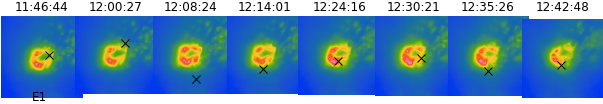

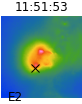

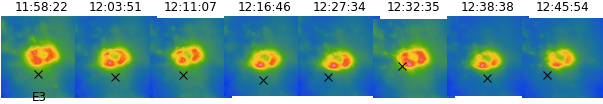

In [11]:
data_by_embryo = data_nkx.set_index("embryo")
p0=2
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[[embryo]]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(1.5*embryo_info.shape[0], 1.5), gridspec_kw={"wspace":-0.5})
        axes = np.array([axes]).ravel()
        shifts = np.load(os.path.join(rootdir, "analysis", subfolder,\
                                      "E%s_registration_shifts.npz"% str(embryo)))["embryo_shifts"]
        print(embryo_info.shape)
        for i in range(embryo_info.shape[0]):
            v,u = shifts[i]
#             print(v,u)
            filename = embryo_info[["file_name"]].values.ravel()[i]
            snap_name = embryo_info[["snap_file"]].values.ravel()[i]
            nkx = skio.imread(os.path.join(rootdir, "Snaps", snap_name))
            nkx = transform.downscale_local_mean(nkx, (4,4))
            mean_img = skio.imread(os.path.join(rootdir, "analysis", subfolder, filename, "mean_img.tif"))
            diff = (nkx.shape[0] - mean_img.shape[0])//2
            if diff > 0:
                nkx = nkx[diff:-diff, diff:-diff]
            nr, nc = nkx.shape
            row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
            nkx = transform.warp(nkx, np.array([row_coords-v, col_coords-u]),\
                                            mode="constant", cval=np.nan)
            
            axes[i].imshow(nkx)
            loi_x = embryo_info[["loi_x_dv"]].values.ravel()[i]
            loi_y = embryo_info[["loi_y_dv"]].values.ravel()[i]
            axes[i].plot(loi_x + u, loi_y + v, "kx")

#             axes[i].plot(loi_x, loi_y, "kx")
#             axes[i].invert_yaxis()
            axes[i].set_axis_off()
            axes[i].set_title(embryo_info[["start_time"]].values.ravel()[i], fontsize=12)
        fig1.text(0.2, 0.1, "E%s" % str(embryo))
        plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_loi_on_structure_nkx.tif" % str(embryo)))

(8, 15)
(1, 15)
(8, 15)


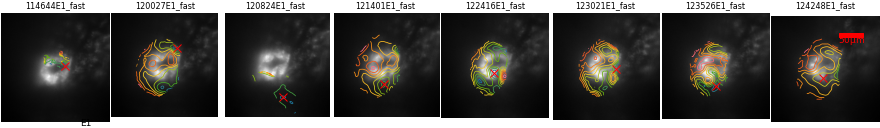

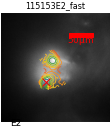

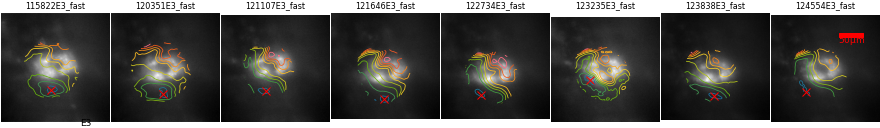

In [9]:
data_by_embryo = data_nkx.set_index("embryo")
p0=2
plt.close("all")
with plt.style.context("../bio_publications.mplstyle"):
    for embryo in data_by_embryo.index.unique():
#     for embryo in [3]:
        embryo_info = data_by_embryo.loc[[embryo]]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(2*embryo_info.shape[0], 2), gridspec_kw={"wspace":-0.1})
        axes = np.array([axes]).ravel()
        shifts = np.load(os.path.join(rootdir, "analysis", subfolder,\
                                      "E%s_registration_shifts.npz"% str(embryo)))["embryo_shifts"]
        print(embryo_info.shape)
        for i in range(embryo_info.shape[0]):
            v,u = shifts[i]
#             print(v,u)
            filename = embryo_info[["file_name"]].values.ravel()[i]
            snap_name = embryo_info[["snap_file"]].values.ravel()[i]

            try:
                nkx = skio.imread(os.path.join(rootdir, "Snaps", snap_name))
            except TypeError as e:
                continue
            nkx = transform.downscale_local_mean(nkx, (4,4))
            mean_img = skio.imread(os.path.join(rootdir, "analysis", subfolder, filename, "mean_img.tif"))
            diff = (nkx.shape[0] - mean_img.shape[0])//2
            if diff > 0:
                nkx = nkx[diff:-diff, diff:-diff]
            nr, nc = nkx.shape
            row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
            matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
            ddict, t = utils.traces_to_dict(matdata)
            dt = np.mean(np.diff(t))
            
            Tsmoothed_dv = smoothed_ts[filename]
            fv = Tsmoothed_dv[np.isfinite(Tsmoothed_dv)]
            Tsmoothed_apod = Tsmoothed_dv - np.percentile(fv, p0)
            nkx = transform.warp(nkx, np.array([row_coords-v, col_coords-u]),\
                                            mode="constant", cval=np.nan)
            
            axes[i].imshow(nkx, cmap="gray")
            
            Tsmoothed_apod = transform.warp(Tsmoothed_apod, np.array([row_coords-v, col_coords-u]),\
                    mode="constant", cval=np.nan)
            
            cs = axes[i].contour(Tsmoothed_apod, levels=8)
            
            loi_x = embryo_info[["loi_x_dv"]].values.ravel()[i]
            loi_y = embryo_info[["loi_y_dv"]].values.ravel()[i]
            axes[i].plot(loi_x + u, loi_y + v, "rx")

#             axes[i].plot(loi_x, loi_y, "kx")
#             axes[i].invert_yaxis()
            axes[i].set_axis_off()
#             axes[i].set_title("%d'" % ((embryo_info[["offset"]].values.ravel()[i] -\
#                                         embryo_info[["offset"]].values.ravel()[0]) /60), fontsize=12)
            axes[i].set_title(filename, fontsize=8)
        visualize.plot_img_scalebar(fig1, axes[-1], 135, 40, 50, 8, pix_per_um = 1/um_per_px, fontsize=9, \
                          color="red", unit="\mu m", yax_direction="up", text_pos="below", scale=0.7, \
                         show_label=True)
        fig1.text(0.2, 0.1, "E%s" % str(embryo))
#         plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_loi_on_structure_nkx.tif" % str(embryo)))

(8, 17)
(1, 17)
(8, 17)


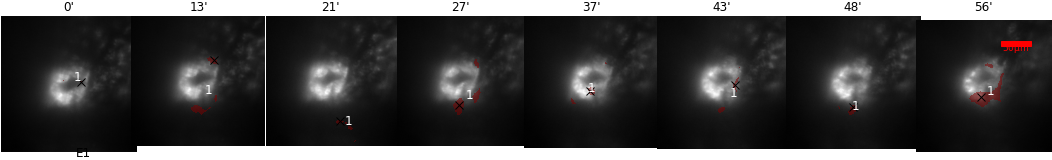

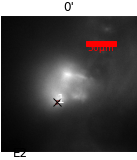

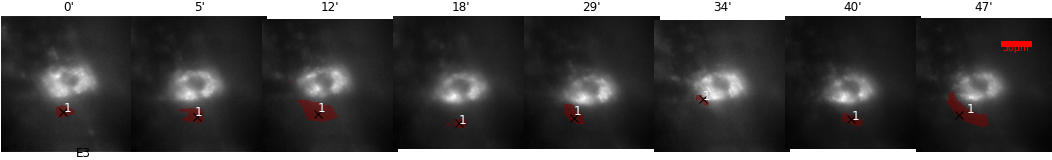

In [10]:
data_nkx[["loi_x_registered", "loi_y_registered", "loi_area"]] = None
data_by_embryo = data_nkx.set_index(["embryo", "start_time"])
p0=2
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    for embryo in data_by_embryo.index.unique("embryo"):
#     for embryo in [3]:
        embryo_info = data_by_embryo.loc[[embryo]]
        fig1, axes = plt.subplots(1, embryo_info.shape[0], figsize=(2.5*embryo_info.shape[0], 2.5), gridspec_kw={"wspace":-0.35})
        axes = np.array([axes]).ravel()
        shifts = np.load(os.path.join(rootdir, "analysis", subfolder,\
                                      "E%s_registration_shifts.npz"% str(embryo)))["embryo_shifts"]
        print(embryo_info.shape)
        
        for i in range(embryo_info.shape[0]):
            v,u = shifts[i]
#             print(v,u)
            filename = embryo_info[["file_name"]].values.ravel()[i]
            snap_name = embryo_info[["snap_file"]].values.ravel()[i]
            start_time = embryo_info.index[i][1]

            try:
                nkx = skio.imread(os.path.join(rootdir, "Snaps", snap_name))
            except TypeError as e:
                continue
            nkx = transform.downscale_local_mean(nkx, (4,4))
            mean_img = skio.imread(os.path.join(rootdir, "analysis", subfolder, filename, "mean_img.tif"))
            diff = (nkx.shape[0] - mean_img.shape[0])//2
            if diff > 0:
                nkx = nkx[diff:-diff, diff:-diff]
            nr, nc = nkx.shape
            row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
            matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
            ddict, t = utils.traces_to_dict(matdata)
            dt = np.mean(np.diff(t))
            
            Tsmoothed_dv = smoothed_ts[filename]
            fv = Tsmoothed_dv[np.isfinite(Tsmoothed_dv)]
            Tsmoothed_apod = Tsmoothed_dv - np.percentile(fv, p0)
            nkx = transform.warp(nkx, np.array([row_coords-v, col_coords-u]),\
                                            mode="constant", cval=np.nan)
            Tsmoothed_apod = transform.warp(Tsmoothed_apod, np.array([row_coords-v, col_coords-u]),\
            mode="constant", cval=np.nan)
            
            loi_x = embryo_info[["loi_x_dv"]].values.ravel()[i] + u
            loi_y = embryo_info[["loi_y_dv"]].values.ravel()[i] + v
            data_by_embryo.loc[(embryo,start_time), "loi_x_registered"] = loi_x
            data_by_embryo.loc[(embryo,start_time),"loi_y_registered"] = loi_y
            mask = (Tsmoothed_apod - Tsmoothed_apod[int(loi_y), int(loi_x)]) < 20
            data_by_embryo.loc[(embryo,start_time),"loi_area"] = np.sum(mask.astype(float))*um_per_px**2
            visualize.display_roi_overlay(nkx, mask, ax=axes[i], mask_cmap="jet_r")
            axes[i].plot(loi_x, loi_y, "kx")

#             axes[i].plot(loi_x, loi_y, "kx")
#             axes[i].invert_yaxis()
            axes[i].set_axis_off()
            axes[i].set_title("%d'" % ((embryo_info[["offset"]].values.ravel()[i] -\
                                        embryo_info[["offset"]].values.ravel()[0]) /60), fontsize=12)
        visualize.plot_img_scalebar(fig1, axes[-1], 135, 40, 50, 8, pix_per_um = 1/um_per_px, fontsize=9, \
                          color="red", unit="\mu m", yax_direction="up", text_pos="below", scale=0.7, \
                         show_label=True)
        fig1.text(0.2, 0.1, "E%s" % str(embryo))
#         plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_loi_on_structure_nkx.tif" % str(embryo)))

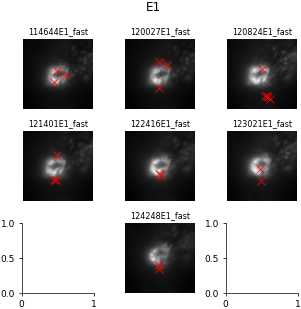

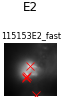

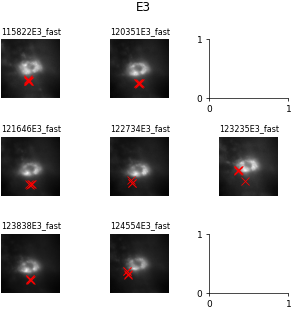

In [12]:
data_by_embryo = data_nkx.set_index("embryo")
with plt.style.context("../bio_publications.mplstyle"):
    for embryo in data_by_embryo.index.unique():
        embryo_info = data_by_embryo.loc[[embryo]]
        filenames = embryo_info[["file_name"]].values.ravel()
#         offset = np.round(embryo_info[["offset"]].values.ravel()/60).astype(int)
        fig1, axes = visualize.tile_plots_conditions(filenames, (1.5,1.5), disp_titles=False)
        for idx, f in enumerate(filenames):
            try:
                bootstrap_data = pd.read_csv(os.path.join(rootdir, "analysis", subfolder, f, "bootstrap", "wavemap_data.csv"))
            except FileNotFoundError:
                continue
            snap_name = embryo_info[["snap_file"]].values.ravel()[idx]

            try:
                nkx = skio.imread(os.path.join(rootdir, "Snaps", snap_name))
            except TypeError as e:
                continue
            nkx = transform.downscale_local_mean(nkx, (4,4))
            mean_img = skio.imread(os.path.join(rootdir, "analysis", subfolder, f, "mean_img.tif"))
            diff = (nkx.shape[0] - mean_img.shape[0])//2
            if diff > 0:
                nkx = nkx[diff:-diff, diff:-diff]
            
            axes[idx].imshow(nkx, cmap="gray")
            axes[idx].scatter(bootstrap_data["loi_x_dv"], bootstrap_data["loi_y_dv"], marker="x", color="red")
            axes[idx].set_title(f, fontsize=8)
#             axes[idx].invert_yaxis()
            axes[idx].set_axis_off()
        fig1.suptitle("E%s" % str(embryo))
        plt.tight_layout()
        plt.savefig(os.path.join(rootdir, "analysis", subfolder, "E%s_bootstrap.tif" % str(embryo)))

In [13]:
all_data = pd.read_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data_full.csv"))
all_data["date"] = "20220203"
all_data.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data_full.csv"), index=False)

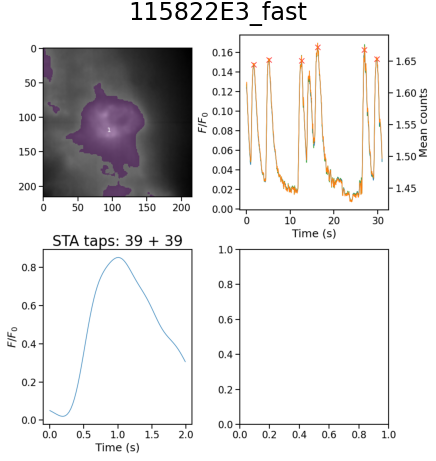

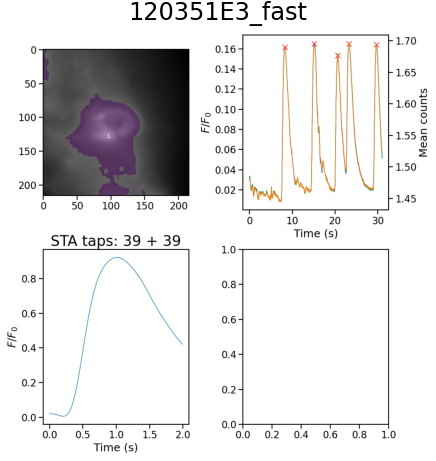

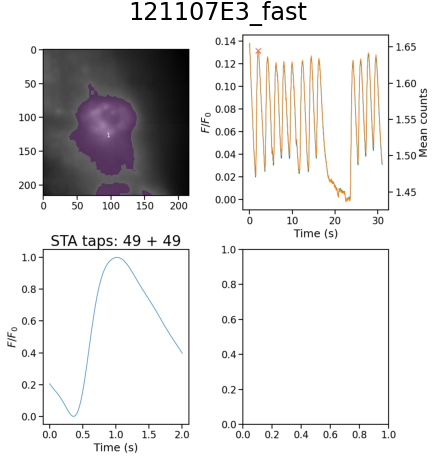

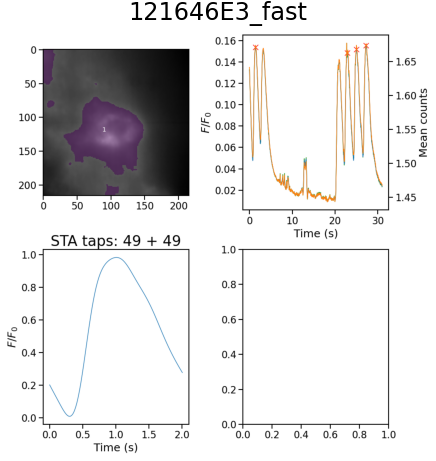

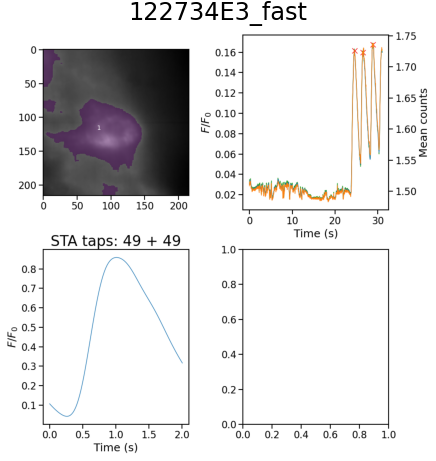

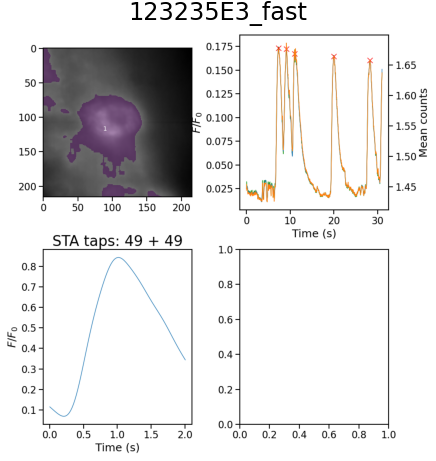

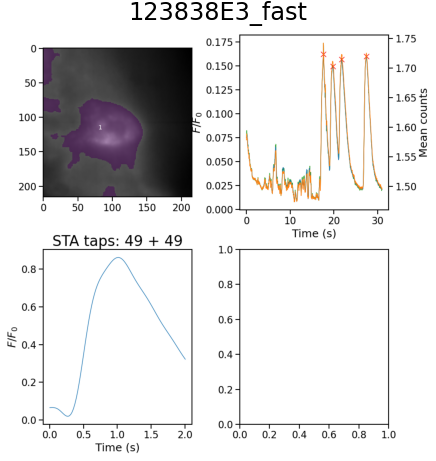

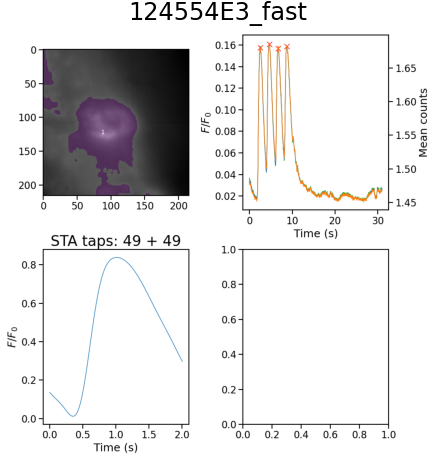

In [11]:
all_data = pd.read_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data_full.csv")).set_index("embryo")
embryo = 3
embryo_data = all_data.loc[[embryo]]
for i in range(embryo_data.shape[0]):
    fig1, ax1 = plt.subplots(figsize=(8,8))
    filename = embryo_data["file_name"].iloc[i]
    im = skio.imread(os.path.join(rootdir, "analysis", subfolder, filename, "QA_plots.tif"))
    ax1.imshow(im)
    ax1.set_axis_off()
    ax1.set_title(filename)

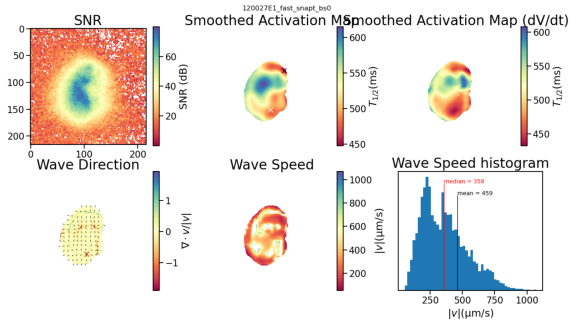

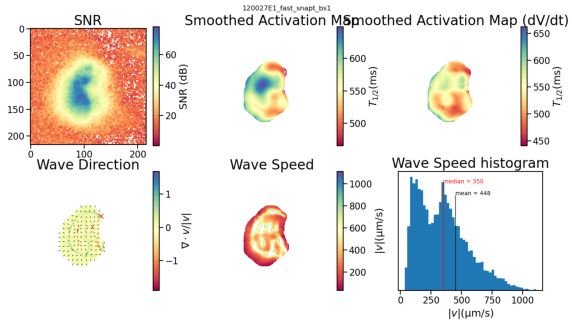

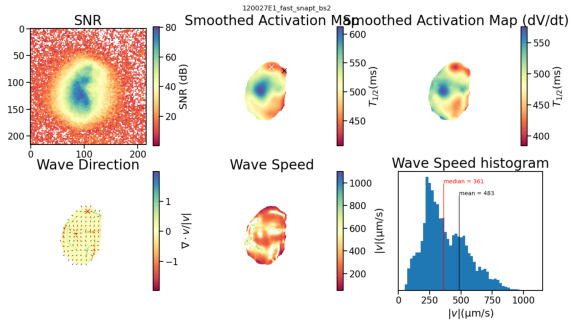

In [17]:
filename = "120027E1_fast"
bootstrap_dir = os.path.join(rootdir, "analysis", subfolder, filename, "bootstrap", "QA_plots")
for f in os.listdir(bootstrap_dir):
    if ".tif" in f:
        fig1, ax1 = plt.subplots(figsize=(12,6))
        im = skio.imread(os.path.join(bootstrap_dir, f))
        ax1.imshow(im)
        ax1.set_axis_off()

In [11]:
data_by_embryo[["loi_displacement_from_start", "loi_total_distance", "rel_offset"]] = None
for embryo in data_by_embryo.index.unique("embryo"):
#     for embryo in [3]:
    loi_x = data_by_embryo.loc[embryo, ["loi_x_registered"]].to_numpy().ravel().astype(float)
    loi_y = data_by_embryo.loc[embryo, ["loi_y_registered"]].to_numpy().ravel().astype(float)
    offset = data_by_embryo.loc[embryo, ["offset"]].to_numpy().ravel().astype(float)
    data_by_embryo.loc[embryo, ["rel_offset"]] = offset - offset[0]
    missing_indices = np.argwhere(np.isnan(loi_x)).ravel()
    try:
        loi_x[missing_indices] = loi_x[np.abs(missing_indices-1)]
        loi_y[missing_indices] = loi_y[np.abs(missing_indices-1)]
    except Exception as e:
        print(e)
        print(embryo)
        continue
    x_diff = np.diff(loi_x, prepend=[loi_x[0]])
    y_diff = np.diff(loi_y, prepend=[loi_y[0]])
    total_distance = np.cumsum((x_diff**2 + y_diff**2)**0.5)
    data_by_embryo.loc[embryo, ["loi_total_distance"]] = total_distance*um_per_px
    displacement = ((loi_x - loi_x[0])**2 + (loi_y - loi_y[0])**2)**0.5
    data_by_embryo.loc[embryo, ["loi_displacement_from_start"]] = displacement*um_per_px

<AxesSubplot:xlabel='rel_offset', ylabel='loi_area'>

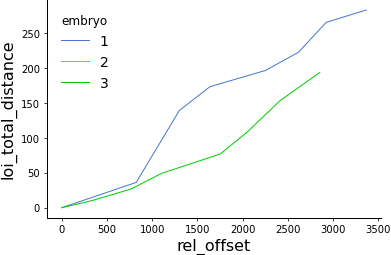

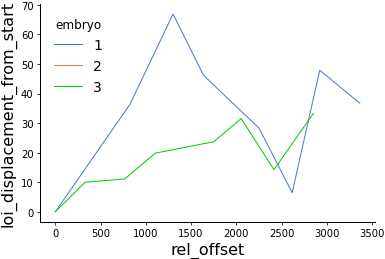

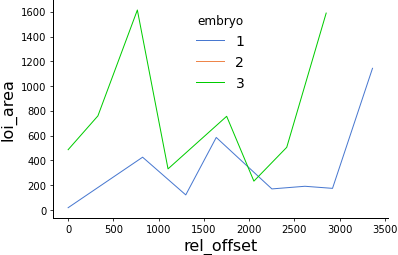

In [15]:
all_data = data_by_embryo.reset_index()
all_data["embryo"] = all_data["embryo"].astype(str)
fig1, ax1 = plt.subplots(figsize=(6,4))
sns.lineplot(data=all_data, x="rel_offset", y="loi_total_distance", hue="embryo", ax=ax1, legend="full")
fig1, ax1 = plt.subplots(figsize=(6,4))
sns.lineplot(data=all_data, x="rel_offset", y="loi_displacement_from_start", hue="embryo", ax=ax1, legend="full")
fig1, ax1 = plt.subplots(figsize=(6,4))
sns.lineplot(data=all_data, x="rel_offset", y="loi_area", hue="embryo", ax=ax1, legend="full")

## Measure distance of LOI from nkx2.5+ region

In [17]:
data_nkx = data_by_embryo.reset_index()
data_nkx["distance_to_cone"] = np.nan
data_nkx["date"] = "20220203"
data_nkx.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"), index=False)
print(data_nkx.shape)

(17, 23)


In [74]:
i = 16
snap_name = data_nkx["snap_file"].iloc[i]
filename = data_nkx["file_name"].iloc[i]
nkx = skio.imread(os.path.join(rootdir, "Snaps", snap_name))
mean_img = skio.imread(os.path.join(rootdir, "analysis", subfolder, filename, "mean_img.tif"))
nkx = transform.downscale_local_mean(nkx, (4,4))
diff = (nkx.shape[0] - mean_img.shape[0])//2
if diff > 0:
    nkx = nkx[diff:-diff, diff:-diff]

(216, 216)
[0 1 2]


<IPython.core.display.Javascript object>


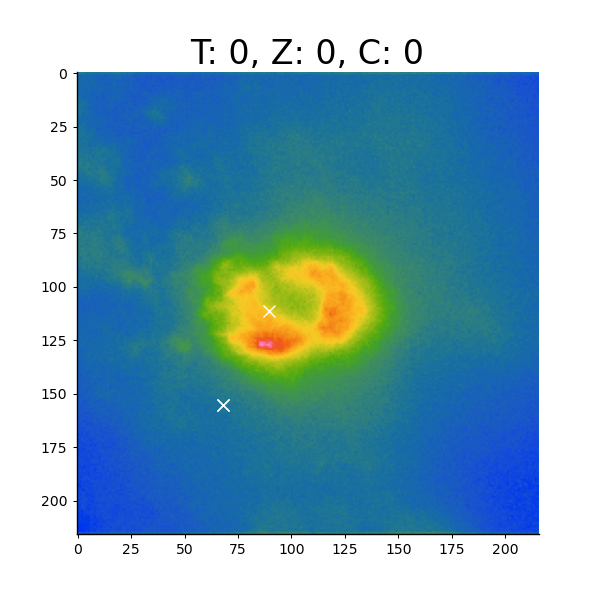

array([[ 68, 155]])

In [75]:
plt.close("all")
%matplotlib notebook
h = stackViewer.HyperStackViewer(nkx, width=6, height=6)
h.points = [[data_nkx["loi_x_dv"].iloc[i], data_nkx["loi_y_dv"].iloc[i]]]
h.select_points_clicky(1, append=True)

In [76]:
points = np.array(h.points)
dist = np.sum(np.diff(points, axis=0)**2)**0.5*um_per_px
data_nkx.at[i, "distance_to_cone"] = dist
data_nkx.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data_full.csv"), index=False)

In [77]:
data_nkx["embryo"] = data_nkx["embryo"].astype(str)

<AxesSubplot:xlabel='rel_offset', ylabel='distance_to_cone'>

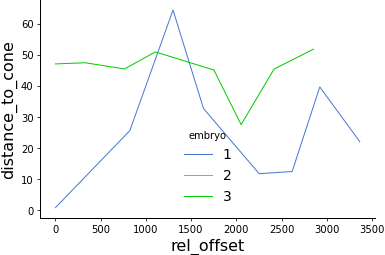

In [78]:
%matplotlib inline
fig1, ax1 = plt.subplots(figsize=(6,4))
sns.lineplot(data=data_nkx, x="rel_offset", y="distance_to_cone", hue="embryo", ax=ax1, legend="full")

### Manual edits

In [ ]:
def mask15(Ts, divergence):
    nan_mask = morphology.binary_dilation(np.pad(np.isnan(Ts),1, constant_values=True), \
                                        footprint=morphology.disk(5))
    
    return np.ma.masked_array(Ts, nan_mask[1:-1,1:-1] |\
                                      (divergence < 0.5))
def mask24(Ts, divergence):
    nan_mask = morphology.binary_dilation(np.pad(np.isnan(Ts),1, constant_values=True), \
                                        footprint=morphology.disk(5))
    
    return np.ma.masked_array(Ts, nan_mask[1:-1,1:-1] |\
                                      (divergence < 0.5))

In [ ]:
data = pd.read_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"))

In [ ]:
data.drop(labels=[0]).to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"))

In [ ]:
data = data.drop(labels=[0])

In [ ]:
data.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"), index=False)

In [ ]:
i = 24

filename = expt_info.iloc[i]["file_name"]
snapt = "%s_snapt.npz" % filename
if snapt in os.listdir(os.path.join(rootdir, "analysis", subfolder)) and "fast" in filename:
    matdata = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
    ddict, t = utils.traces_to_dict(matdata)
    dt = np.mean(np.diff(t))

    beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]

    try:
        amplitude = beta[2]
        amplitude = amplitude[~np.isnan(amplitude)]
        threshold = min(np.percentile(amplitude, 45), 1.01)
        q = analyze_wave_dynamics(beta, dt, um_per_px, threshold, mask_function_tsmoothed=mask24)
        if q is None:
            raise
        else:
            rd, Tsmoothed, Tsmoothed_dv, divergence, v = q
            rowdata = tuple(expt_info.iloc[i]) + rd
            print(rowdata)
    except Exception as e:
        erred_files[filename] = e

    smoothed_ts[filename] = Tsmoothed_dv
    amplitudes[filename] = beta[2]
    divergences[filename] = divergence
    plot_wave_analysis(beta[2], Tsmoothed, Tsmoothed_dv,\
                       divergence, v, "%d, %s" % (i, expt_info.iloc[i]["file_name"]))

In [ ]:
data.at[data["file_name"]==filename] = rowdata

In [ ]:
%matplotlib inline
files = data["file_name"].to_list()
fig1, axes = visualize.tile_plots_conditions(files, (4,4))
axes = axes.ravel()
mean_imgs = {}
amplitudes = {}
for idx, f in enumerate(files):
    img = skio.imread(os.path.join(rootdir, "downsampled", "%s.tif" % f))
    mean_img = img.mean(axis=0)
    mean_imgs[f] = mean_img
    axes[idx].imshow(mean_img)
    axes[idx].set_axis_off()
    snapt = "%s_snapt.npz" % f
    beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]
    amplitudes[f] = beta[2]
plt.tight_layout()
plt.savefig(os.path.join(rootdir, "analysis", subfolder, "mean_images.tif"), dpi=300)

In [ ]:
# data.at[7,["mean_speed", "median_speed", "loi_x", "loi_y"]] = [mean, median,\
#                                               min_activation_time[1], min_activation_time[0]]

In [ ]:
data = pd.read_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"))

In [ ]:
data.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"), index=False)

In [ ]:
data[["ref1_x", "ref1_y", "ref2_x", "ref2_y"]] = np.nan

### Calculate reference points for hearts

In [ ]:
data.shape[0]

In [ ]:
%matplotlib notebook
i = 26
fname = data["file_name"].iloc[i]
print(fname)
snapt = "%s_snapt.npz" % fname
beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]
amplitude = beta[2]
h = HyperStackViewer(amplitude, width=6, height=6)
h.select_points_clicky(2)

In [ ]:
data.at[i,["ref1_x", "ref1_y", "ref2_x", "ref2_y"]] = [h.points[0][0], h.points[0][1], h.points[1][0], h.points[1][1]]

In [ ]:
data["experiment"] = "20210923_25x_gcamp_focus"
data[["imheight", "imwidth"]] = amplitude.shape

In [ ]:
data.at[23, "embryo"] = 8
data.at[17, "embryo"] = 8

In [ ]:
data

In [ ]:
sorted_by_embryo = data.set_index("embryo").sort_index()

In [ ]:
edata

In [ ]:
axis_length = ((data["ref1_x"] - data["ref2_x"])**2 + (data["ref1_y"] - data["ref2_y"])**2)**0.5

In [ ]:
plt.hist(axis_length)

In [ ]:
data.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"), index=False)

### Check reference axis labeling

In [ ]:
!ls {os.path.join(rootdir, "Snaps")}

In [ ]:
data_by_embryo = data.set_index("embryo")
data_by_embryo.index.unique()

In [ ]:
embryo = 13
edata = data_by_embryo.loc[embryo]

In [ ]:
files = list(edata["file_name"])
fig1, axes = visualize.tile_plots_conditions(files, (5,5))
for i in range(edata.shape[0]):
    axes[i].imshow(mean_imgs[files[i]], cmap="gray")
    cs = axes[i].contour(amplitudes[files[i]], alpha=0.5, levels=5)
    plt.colorbar(cs, ax=axes[i])
    x1, y1, x2, y2 = edata.iloc[i][["ref1_x", "ref1_y", "ref2_x", "ref2_y"]]
    axes[i].plot([x1,x2], [y1,y2])

In [ ]:
files = list(edata["file_name"])
fig1, axes = visualize.tile_plots_conditions(files, (5,5))
for i in range(edata.shape[0]):
    axes[i].imshow(mean_imgs[files[i]], cmap="gray")
    cs = axes[i].contour(smoothed_ts[files[i]], alpha=0.5, levels=10)
    plt.colorbar(cs, ax=axes[i])
    x1, y1, x2, y2 = edata.iloc[i][["ref1_x", "ref1_y", "ref2_x", "ref2_y"]]
    axes[i].plot([x1,x2], [y1,y2])

In [ ]:
%matplotlib notebook
i = 1
fname = files[i]
print(fname)
# snapt = "%s_snapt.npz" % fname
# beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]
# amplitude = beta[2]
h = HyperStackViewer(mean_imgs[fname], width=6, height=6)
h.select_points_clicky(2)

In [ ]:
full_table_loc = data.loc[data["file_name"]==fname].index[0]
data.at[full_table_loc,["ref1_x", "ref1_y", "ref2_x", "ref2_y"]] = [h.points[0][0], h.points[0][1], h.points[1][0], h.points[1][1]]

In [ ]:
data.to_csv(os.path.join(rootdir, "analysis", subfolder, "wavefront_data.csv"), index=False)